## Functions and libraries 

In [136]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from gplearn.genetic import SymbolicTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

## Functions for classifier in cross classification

In [11]:
classifiers = {
    "RBF SVM": SVC(gamma=2, C=1),
    "Logistic Regression": LogisticRegression( solver='lbfgs', max_iter = 500 ), 
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=500),
    "AdaBoost" : AdaBoostClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

def profit_scorer(y, y_pred):
#     print(confusion_matrix(y, y_pred))
    profit_matrix = {(0,0): 0, (0,1): -5, (1,0): -25, (1,1): 5}
    return sum(profit_matrix[(pred, actual)] for pred, actual in zip(y_pred, y))

def evaluate_classification(X, y):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    profit_scoring = make_scorer(profit_scorer, greater_is_better=True)
    
    for name, clf in classifiers.items():
#         print(cross_validate(clf, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])
        result = sum(cross_validate(clf, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])
        print(f"{name}: test core = {result} ")
def code_for_test(X,y):
    """
    test code with 10-fold stratified cross validation
    parameters
    X: trainset features after generation
    y: trainset y label
    """
    evaluate_classification(X, y)

## functions for feature selection

In [13]:
def feature_selection(X, y):
    model = LogisticRegression(solver='lbfgs', max_iter=300)
    models = {'logistic': model, 'RFE': RFE(model, 5), 'ridge': Ridge(alpha=1.0), 'Lasso': Lasso()}
    for k, v in models.items():
        print(k)
        fit = v.fit(X, y)
        if k == 'RFE':
            print("Num Features: %s" % (fit.n_features_))
            print("Feature Ranking: %s" % (fit.ranking_))
            for i, j in sorted(zip(fit.ranking_, X.columns), reverse=False):
                print(i,j)

        elif k == 'logistic':
            for i, j in sorted(zip(map(lambda x: round(x, 4), fit.coef_.reshape(-1)), X.columns), reverse=True):
                print(i,j)
        else:
            for i, j in sorted(zip(map(lambda x: round(x, 4), abs(fit.coef_)), X.columns), reverse=True):
                print(i,j)

## Functions for automatic feature generation

In [14]:
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']  # 
def gp(X, y, gen, n_com, feature_set):
    gp = SymbolicTransformer(generations=gen, population_size=1000,
                             hall_of_fame=1000, n_components=n_com,
                             function_set=function_set,
                             parsimony_coefficient=0.0005,
                             max_samples=0.9, verbose=1,
                             random_state=42, n_jobs=3,
                             feature_names=X.columns)
    x_gp = gp.fit_transform(X, y)
    print(x_gp)
    print(x_gp.shape)
    code_for_test(x_gp, y)

## functions for semi-supervised learning

In [15]:
def classify(X_train, X_test, y_train, clf):
    pred = clf.fit(X_train, y_train).predict(X_test)
    return pred

def cv_cost(X, X_test_other, y):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    cost = {"RBF SVM": 0,
    "Logistic Regression": 0, 
    "Neural Net": 0,
    "Random Forest": 0,
    "AdaBoost" : 0,
    "XGBoost": 0}
    for train_index, test_index in cv.split(X, y):
        # get the split
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        # generate coresponding test label
        # model = LabelSpreading(gamma=10)
        # model = LabelPropagation(alpha=None, gamma=10, kernel='rbf', max_iter=1000,n_jobs=None, n_neighbors=7, tol=0.001)
        model = LabelSpreading(alpha=0.2, gamma=10, kernel='rbf', max_iter=30, n_jobs=None,n_neighbors=7, tol=0.001)
        y_new_label = model.fit(X_train, y_train).predict(X_test_other)
        X_all = X_train.append(X_test_other)
        
        y_all = y_train.append(pd.DataFrame(y_new_label))
        # evaluation 
        for name, clf in classifiers.items():
            pred = classify(X_all, X_test, y_all, clf)
            cost[name] += profit_scorer(y_test, pred>0.5)
    print(f'cost = {cost}')

## functions for cost-sensitive xgboost

In [16]:
def logistic_obj(y_hat, dtrain, alpha=5, beta=25): # alpha for FN beta for FP
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-y_hat))
    grad = pred * (beta + alpha*y - beta*y) - alpha*y  # alpha*(p-1)*y + beta*p*(1-y)
    hess = pred * (1 - pred) * (beta + alpha*y - beta*y)
    return grad, hess

def err_rate(pred, dtrain):
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-pred))
    loss_fn = y*np.log(pred)
    loss_fp = (1.0 - y)*np.log(1.0 - pred)
    return 'error', np.sum(-(5*loss_fn+25*loss_fp))/len(y)

def cross_validation(X_train, X_test, y_train, y_test, depth, num_round):
    # load data
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_val = xgb.DMatrix(X_test, label=y_test)
    # build model
    param = {'max_depth': depth, 'eta': 0.2, 'silent': 1, 'seed': 42, 'scale_pos_weight':1}
#     watchlist = [(d_val, 'eval'), (d_train, 'train')]
#     model_trn = xgb.train(param, d_train, num_round, watchlist, obj=logistic_obj, feval=err_rate)
    model_trn = xgb.train(param, d_train, num_round, obj=logistic_obj, feval=err_rate)
    # prediction
    pred = model_trn.predict(d_val) 
    pred = 1. / (1. + np.exp(-pred))
    return pred
def cv_cost(X,y, depth, rounds):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    cost=0
    if type(X) == pd.DataFrame:
        X=X.values
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pred = cross_validatation(X_train, X_test, y_train, y_test, depth, rounds)
#         print(f' confusion matrix: cost({profit_scorer(y_test, pred>0.5)})\n {confusion_matrix(y_test, pred>0.5)}')
        cost += profit_scorer(y_test, pred>0.5)

    print(f'cost = {cost}')

## Dataset for test
prepare different input dataset and test at 10-fold stratified cross validation set


**1. X (raw data)**

In [19]:
train_data = pd.read_csv('data/train.csv', sep = '|')
test_data = pd.read_csv('data/test.csv', sep = '|')
print(f'Train set has {train_data.shape[0]} entries and {train_data.shape[1]} features')
print(f'Test set has {test_data.shape[0]} entries and {test_data.shape[1]} features')
y = train_data['fraud']
X = train_data.drop(columns=['fraud']).astype(float)


Train set has 1879 entries and 10 features
Test set has 498121 entries and 9 features


In [26]:
code_for_test(X_train_manual, y)

RBF SVM: test core = 70 
Logistic Regression: test core = -5 
Neural Net: test core = -40 
Random Forest: test core = 140 
AdaBoost: test core = 195 
XGBoost: test core = 110 


**2. X_train_norm data (normalized)**

In [21]:
fit_minmax = MinMaxScaler()
X_train_norm = pd.DataFrame(fit_minmax.fit_transform(X), columns=X.columns, index=X.index)
print(X_train_norm.shape)
X_test_norm = pd.DataFrame(fit_minmax.transform(test_data), columns=test_data.columns, index=test_data.index)

(1879, 9)


In [26]:
code_for_test(X_train_manual, y)

RBF SVM: test core = 70 
Logistic Regression: test core = -5 
Neural Net: test core = -40 
Random Forest: test core = 140 
AdaBoost: test core = 195 
XGBoost: test core = 110 


**3. X_train_norm_enc data (normalized and encode)**

In [23]:
fit_minmax = MinMaxScaler()
X_encode = pd.get_dummies(X, columns=['trustLevel'], prefix='trustLevel')
X_train_norm_enc = pd.DataFrame(fit_minmax.fit_transform(X_encode), columns=X_encode.columns, index=X_encode.index)
print(X_train_norm_enc.shape)
X_test_encode = pd.get_dummies(test_data, columns=['trustLevel'], prefix='trustLevel')
X_test_norm_enc = pd.DataFrame(fit_minmax.transform(X_test_encode), columns=X_test_encode.columns, index=X_test_encode.index)

(1879, 14)


In [26]:
code_for_test(X_train_manual, y)

RBF SVM: test core = 70 
Logistic Regression: test core = -5 
Neural Net: test core = -40 
Random Forest: test core = 140 
AdaBoost: test core = 195 
XGBoost: test core = 110 


## 1. Feature Generation - Manual delete and create 
   - encode trustLevel
   - delete 'valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'
   - generate no. item = totalScanTimeInSeconds * scannedLineItemsPerSecond

**4. X_train_manual (manual)** <br>
**5. X_train_manual_enc (manual and encode)**

In [25]:
## delete correlate features
X_manual = X.assign(no_item = X.totalScanTimeInSeconds* X.scannedLineItemsPerSecond)\
                     .drop(columns=['valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'])
X_test = test_data.assign(no_item = test_data.totalScanTimeInSeconds* test_data.scannedLineItemsPerSecond)\
                     .drop(columns=['valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'])

fit_minmax = MinMaxScaler()

X_train_manual = pd.DataFrame(fit_minmax.fit_transform(X_manual), columns=X_manual.columns, index=X_manual.index)
X_test_manual = pd.DataFrame(fit_minmax.transform(X_test), columns=X_test.columns, index=X_test.index)
print(X_train_manual.shape)
print(X_test_manual.shape)

X_manual_encode = pd.get_dummies(X_manual, columns=['trustLevel'], prefix='trustLevel')
X_test_encode = pd.get_dummies(X_test, columns=['trustLevel'], prefix='trustLevel')

X_train_manual_enc = pd.DataFrame(fit_minmax.fit_transform(X_manual_encode), columns=X_manual_encode.columns, index=X_manual_encode.index)
X_test_manual_enc = pd.DataFrame(fit_minmax.transform(X_test_encode), columns=X_manual_encode.columns, index=X_test_encode.index)
print(X_train_manual_enc.columns)
print(X_test_manual_enc.columns)


(1879, 7)
(498121, 7)
Index(['totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications', 'no_item',
       'trustLevel_1.0', 'trustLevel_2.0', 'trustLevel_3.0', 'trustLevel_4.0',
       'trustLevel_5.0', 'trustLevel_6.0'],
      dtype='object')
Index(['totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications', 'no_item',
       'trustLevel_1.0', 'trustLevel_2.0', 'trustLevel_3.0', 'trustLevel_4.0',
       'trustLevel_5.0', 'trustLevel_6.0'],
      dtype='object')


In [26]:
code_for_test(X_train_manual, y)

RBF SVM: test core = 70 
Logistic Regression: test core = -5 
Neural Net: test core = -40 
Random Forest: test core = 140 
AdaBoost: test core = 195 
XGBoost: test core = 110 


In [27]:
code_for_test(X_train_manual_enc, y)

RBF SVM: test core = 225 
Logistic Regression: test core = 205 
Neural Net: test core = 200 
Random Forest: test core = 115 
AdaBoost: test core = 135 
XGBoost: test core = 80 


## feature selection
1. grandtotal, quantitymodification still not significant
2. remove => get better score for adaboost 235

In [29]:
feature_selection(X_train_manual_enc, y)

logistic
6.8858 no_item
3.976 trustLevel_1.0
2.7258 totalScanTimeInSeconds
1.6393 scansWithoutRegistration
1.2608 trustLevel_2.0
1.2442 lineItemVoids
0.3383 grandTotal
0.1721 quantityModifications
-1.1386 trustLevel_4.0
-1.2942 trustLevel_5.0
-1.3767 trustLevel_6.0
-1.4265 trustLevel_3.0
RFE
Num Features: 5
Feature Ranking: [1 7 2 1 8 1 1 1 3 6 5 4]
1 no_item
1 scansWithoutRegistration
1 totalScanTimeInSeconds
1 trustLevel_1.0
1 trustLevel_2.0
2 lineItemVoids
3 trustLevel_3.0
4 trustLevel_6.0
5 trustLevel_5.0
6 trustLevel_4.0
7 grandTotal
8 quantityModifications
ridge
0.2196 no_item
0.2134 trustLevel_1.0
0.0941 totalScanTimeInSeconds
0.0636 scansWithoutRegistration
0.0587 trustLevel_6.0
0.0546 trustLevel_3.0
0.0514 trustLevel_5.0
0.0461 trustLevel_4.0
0.0301 lineItemVoids
0.0176 grandTotal
0.0082 quantityModifications
0.0027 trustLevel_2.0
Lasso
0.0 trustLevel_6.0
0.0 trustLevel_5.0
0.0 trustLevel_4.0
0.0 trustLevel_3.0
0.0 trustLevel_2.0
0.0 trustLevel_1.0
0.0 totalScanTimeInSeconds
0

In [30]:
code_for_test(X_train_manual_enc.drop(columns=['grandTotal','quantityModifications']), y)

RBF SVM: test core = 115 
Logistic Regression: test core = 230 
Neural Net: test core = 220 
Random Forest: test core = 140 
AdaBoost: test core = 235 
XGBoost: test core = 100 


## test on trustLevel
1. remove => model collapse
2. only level 1, 2 => worse
3. only level 1, 2 but encode => worse 


In [31]:
X_train_notrustlevel = X_train_manual.iloc[:,:6]
# print(X_train_notrustlevel.shape)
code_for_test(X_train_notrustlevel, y)

RBF SVM: test core = -520 
Logistic Regression: test core = -540 
Neural Net: test core = -510 
Random Forest: test core = -895 
AdaBoost: test core = -1070 
XGBoost: test core = -1010 


In [70]:
X_train_trustlevel_12 = X_train_manual[X_train_manual['trustLevel']<0.3]
y_trust12 = y[X_train_manual['trustLevel']<0.3]
code_for_test(X_train_trustlevel_12, y_trust12)

RBF SVM: test core = 25 
Logistic Regression: test core = 100 
Neural Net: test core = -400 
Random Forest: test core = 135 
AdaBoost: test core = 150 
XGBoost: test core = 210 


In [78]:
X_train_trustlevel_12_enc = X_train_manual_enc[X_train_manual_enc['trustLevel_1.0']==1].append(X_train_manual_enc[X_train_manual_enc['trustLevel_2.0']==1]).iloc[:,:8]
y_trust12_enc = y[X_train_manual_enc['trustLevel_1.0']==1].append(y[X_train_manual_enc['trustLevel_2.0']==1])
code_for_test(X_train_trustlevel_12_enc, y_trust12_enc)

RBF SVM: test core = 130 
Logistic Regression: test core = 140 
Neural Net: test core = -80 
Random Forest: test core = 100 
AdaBoost: test core = 45 
XGBoost: test core = 150 


## 2. Feature generation - PCA
1. with encode w/o encode => PCA distribution different
2. result not improve

In [68]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 'mle')
# original
X_train_PCA = pca.fit_transform(X)
X_test_PCA = pca.transform(test_data)
print('original ', pca.n_components_)

# nomalize
X_train_PCA_norm = pca.fit_transform(X_train_norm)
X_test_PCA_norm = pca.transform(X_test_norm)
print('normalize ', pca.n_components_)

# normalize encode
X_train_PCA_norm_enc = pca.fit_transform(X_train_norm_enc)
X_test_PCA_norm_enc = pca.transform(X_test_norm_enc)
print('normalize encode', pca.n_components_)

# nmanual 
X_train_PCA_manual = pca.fit_transform(X_train_manual)
X_test_PCA_manual = pca.transform(X_test_manual)
print('manual', pca.n_components_)

# nmanual encode
X_train_PCA_manual_enc = pca.fit_transform(X_train_manual_enc)
X_test_PCA_manual_enc = pca.transform(X_test_manual_enc)
print('manual encode', pca.n_components_)

# without truseLevel
X_train_PCA_notrust = pca.fit_transform(X_train_notrustlevel)
print('w/o trust', pca.n_components_)

# with trustLevel1,2
X_train_PCA_trust12 = pca.fit_transform(X_train_trustlevel_12)
print('w/ 12', pca.n_components_)
# with trustLevel1,2
X_train_PCA_trust12_enc = pca.fit_transform(X_train_trustlevel_12_enc)
print('w/ 12', pca.n_components_)


original  8
normalize  8
normalize encode 13
manual 2
manual encode 11
w/o trust 2
w/ 12 6
w/ 12 7


Text(0.5, 1.0, 'trust12 norm/enc')

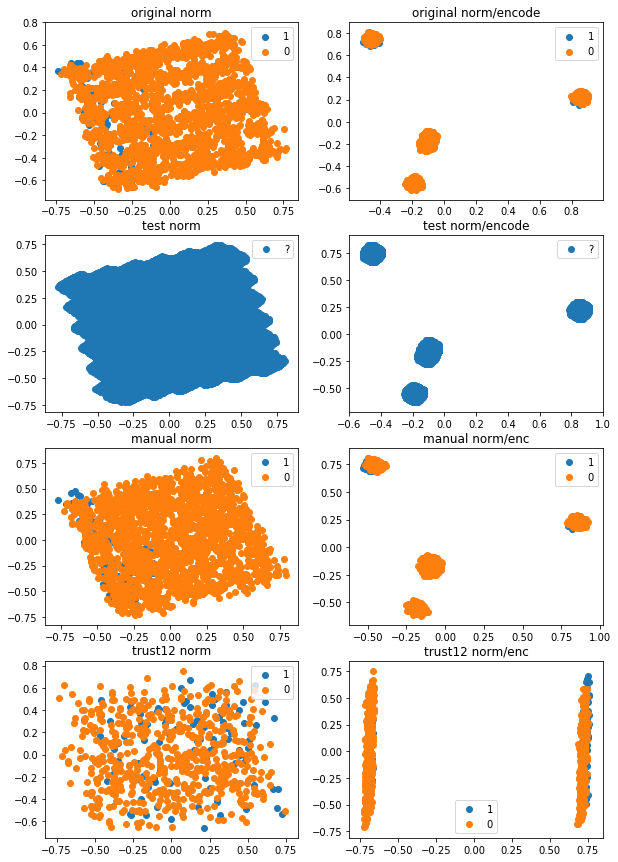

In [99]:
fig, ax = plt.subplots(4,2)
fig.set_figheight(15)
fig.set_figwidth(10)
ax[0,0].scatter(X_train_PCA_norm[y==1,0], X_train_PCA_norm[y==1,1], label='1')
ax[0,0].scatter(X_train_PCA_norm[y==0,0], X_train_PCA_norm[y==0,1], label='0')
ax[0,0].legend()
ax[0,0].set_title('original norm')
ax[0,1].scatter(X_train_PCA_norm_enc[y==1,0], X_train_PCA_norm_enc[y==1,1], label='1')
ax[0,1].scatter(X_train_PCA_norm_enc[y==0,0], X_train_PCA_norm_enc[y==0,1], label='0')
ax[0,1].legend()
ax[0,1].set_title('original norm/encode')

ax[1,0].scatter(X_test_PCA_norm[:,0], X_test_PCA_norm[:,1], label='?')
ax[1,0].legend()
ax[1,0].set_title('test norm')
ax[1,1].scatter(X_test_PCA_norm_enc[:,0], X_test_PCA_norm_enc[:,1], label='?')
ax[1,1].legend()
ax[1,1].set_title('test norm/encode')

ax[2,0].scatter(X_train_PCA_manual[y==1,0], X_train_PCA_manual[y==1,1], label='1')
ax[2,0].scatter(X_train_PCA_manual[y==0,0], X_train_PCA_manual[y==0,1], label='0')
ax[2,0].legend()
ax[2,0].set_title('manual norm')
ax[2,1].scatter(X_train_PCA_manual_enc[y==1,0], X_train_PCA_manual_enc[y==1,1], label='1')
ax[2,1].scatter(X_train_PCA_manual_enc[y==0,0], X_train_PCA_manual_enc[y==0,1], label='0')
ax[2,1].legend()
ax[2,1].set_title('manual norm/enc')

ax[3,0].scatter(X_train_PCA_trust12[y_trust12==1,0], X_train_PCA_trust12[y_trust12==1,1], label='1')
ax[3,0].scatter(X_train_PCA_trust12[y_trust12==0,0], X_train_PCA_trust12[y_trust12==0,1], label='0')
ax[3,0].legend()
ax[3,0].set_title('trust12 norm')
ax[3,1].scatter(X_train_PCA_trust12_enc[y_trust12_enc==1,0], X_train_PCA_trust12_enc[y_trust12_enc==1,1], label='1')
ax[3,1].scatter(X_train_PCA_trust12_enc[y_trust12_enc==0,0], X_train_PCA_trust12_enc[y_trust12_enc==0,1], label='0')
ax[3,1].legend()
ax[3,1].set_title('trust12 norm/enc')

Text(0.5, 1.0, 'trust12 norm/enc')

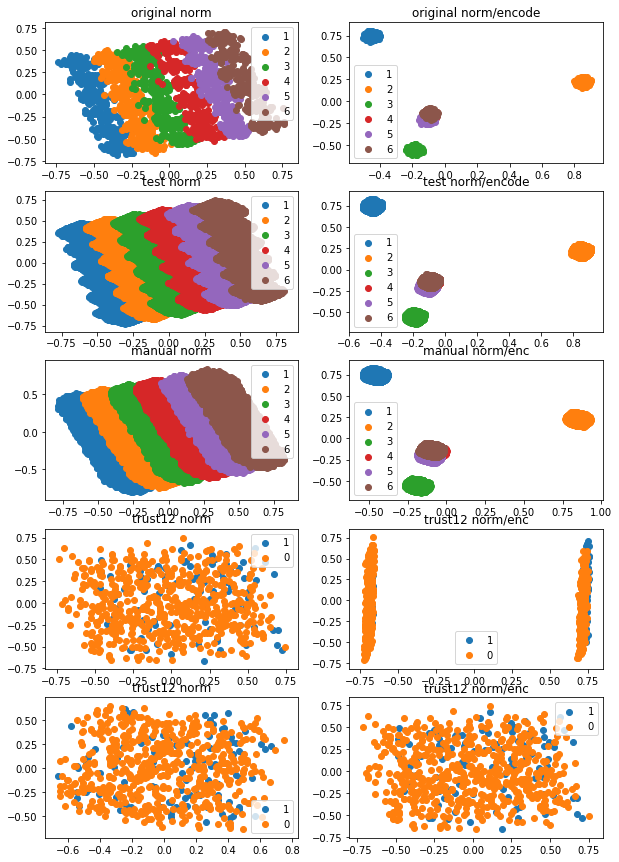

In [133]:
fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(10)
ax[0,0].scatter(X_train_PCA_norm[X_train_norm['trustLevel']== 0.0,0], X_train_PCA_norm[X_train_norm['trustLevel']== 0.0,1], label='1')
ax[0,0].scatter(X_train_PCA_norm[X_train_norm['trustLevel']== 0.2,0], X_train_PCA_norm[X_train_norm['trustLevel']== 0.2,1], label='2')
ax[0,0].scatter(X_train_PCA_norm[X_train_norm['trustLevel']== 0.4000000000000001,0], X_train_PCA_norm[X_train_norm['trustLevel']== 0.4000000000000001,1], label='3')
ax[0,0].scatter(X_train_PCA_norm[X_train_norm['trustLevel']== 0.6000000000000001,0], X_train_PCA_norm[X_train_norm['trustLevel']== 0.6000000000000001,1], label='4')
ax[0,0].scatter(X_train_PCA_norm[X_train_norm['trustLevel']== 0.8,0], X_train_PCA_norm[X_train_norm['trustLevel']== 0.8,1], label='5')
ax[0,0].scatter(X_train_PCA_norm[X_train_norm['trustLevel']== 1.0000000000000002,0], X_train_PCA_norm[X_train_norm['trustLevel']== 1.0000000000000002,1], label='6')
ax[0,0].legend()
ax[0,0].set_title('original norm')

ax[0,1].scatter(X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0,0], X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0,1], label='1')
ax[0,1].scatter(X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.2,0], X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.2,1], label='2')
ax[0,1].scatter(X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.4000000000000001,0], X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.4000000000000001,1], label='3')
ax[0,1].scatter(X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.6000000000000001,0], X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.6000000000000001,1], label='4')
ax[0,1].scatter(X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.8,0], X_train_PCA_norm_enc[X_train_norm['trustLevel']== 0.8,1], label='5')
ax[0,1].scatter(X_train_PCA_norm_enc[X_train_norm['trustLevel']== 1.0000000000000002,0], X_train_PCA_norm_enc[X_train_norm['trustLevel']== 1.0000000000000002,1], label='6')
ax[0,1].legend()
ax[0,1].set_title('original norm/encode')

ax[1,0].scatter(X_test_PCA_norm[X_test_norm['trustLevel']== 0,0], X_test_PCA_norm[X_test_norm['trustLevel']== 0,1], label='1')
ax[1,0].scatter(X_test_PCA_norm[X_test_norm['trustLevel']== 0.2,0], X_test_PCA_norm[X_test_norm['trustLevel']== 0.2,1], label='2')
ax[1,0].scatter(X_test_PCA_norm[X_test_norm['trustLevel']== 0.4000000000000001,0], X_test_PCA_norm[X_test_norm['trustLevel']== 0.4000000000000001,1], label='3')
ax[1,0].scatter(X_test_PCA_norm[X_test_norm['trustLevel']== 0.6000000000000001,0], X_test_PCA_norm[X_test_norm['trustLevel']== 0.6000000000000001,1], label='4')
ax[1,0].scatter(X_test_PCA_norm[X_test_norm['trustLevel']== 0.8,0], X_test_PCA_norm[X_test_norm['trustLevel']== 0.8,1], label='5')
ax[1,0].scatter(X_test_PCA_norm[X_test_norm['trustLevel']== 1.0000000000000002,0], X_test_PCA_norm[X_test_norm['trustLevel']== 1.0000000000000002,1], label='6')
# ax[1,0].scatter(X_test_PCA_norm[:,0], X_test_PCA_norm[:,1], label='?')
ax[1,0].legend()
ax[1,0].set_title('test norm')

ax[1,1].scatter(X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0,0], X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0,1], label='1')
ax[1,1].scatter(X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.2,0], X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.2,1], label='2')
ax[1,1].scatter(X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.4000000000000001,0], X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.4000000000000001,1], label='3')
ax[1,1].scatter(X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.6000000000000001,0], X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.6000000000000001,1], label='4')
ax[1,1].scatter(X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.8,0], X_test_PCA_norm_enc[X_test_norm['trustLevel']== 0.8,1], label='5')
ax[1,1].scatter(X_test_PCA_norm_enc[X_test_norm['trustLevel']== 1.0000000000000002,0], X_test_PCA_norm_enc[X_test_norm['trustLevel']== 1.0000000000000002,1], label='6')
# ax[1,1].scatter(X_test_PCA_norm_enc[:,0], X_test_PCA_norm_enc[:,1], label='?')
ax[1,1].legend()
ax[1,1].set_title('test norm/encode')

ax[2,0].scatter(X_test_PCA_manual[X_test_norm['trustLevel']== 0,0], X_test_PCA_manual[X_test_norm['trustLevel']== 0,1], label='1')
ax[2,0].scatter(X_test_PCA_manual[X_test_norm['trustLevel']== 0.2,0], X_test_PCA_manual[X_test_norm['trustLevel']== 0.2,1], label='2')
ax[2,0].scatter(X_test_PCA_manual[X_test_norm['trustLevel']== 0.4000000000000001,0], X_test_PCA_manual[X_test_norm['trustLevel']== 0.4000000000000001,1], label='3')
ax[2,0].scatter(X_test_PCA_manual[X_test_norm['trustLevel']== 0.6000000000000001,0], X_test_PCA_manual[X_test_norm['trustLevel']== 0.6000000000000001,1], label='4')
ax[2,0].scatter(X_test_PCA_manual[X_test_norm['trustLevel']== 0.8,0], X_test_PCA_manual[X_test_norm['trustLevel']== 0.8,1], label='5')
ax[2,0].scatter(X_test_PCA_manual[X_test_norm['trustLevel']== 1.0000000000000002,0], X_test_PCA_manual[X_test_norm['trustLevel']== 1.0000000000000002,1], label='6')
ax[2,0].legend()
ax[2,0].set_title('manual norm')

ax[2,1].scatter(X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0,0], X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0,1], label='1')
ax[2,1].scatter(X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.2,0], X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.2,1], label='2')
ax[2,1].scatter(X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.4000000000000001,0], X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.4000000000000001,1], label='3')
ax[2,1].scatter(X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.6000000000000001,0], X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.6000000000000001,1], label='4')
ax[2,1].scatter(X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.8,0], X_test_PCA_manual_enc[X_test_norm['trustLevel']== 0.8,1], label='5')
ax[2,1].scatter(X_test_PCA_manual_enc[X_test_norm['trustLevel']== 1.0000000000000002,0], X_test_PCA_manual_enc[X_test_norm['trustLevel']== 1.0000000000000002,1], label='6')
ax[2,1].legend()
ax[2,1].set_title('manual norm/enc')

ax[3,0].scatter(X_train_PCA_trust12[y_trust12==1,0], X_train_PCA_trust12[y_trust12==1,1], label='1')
ax[3,0].scatter(X_train_PCA_trust12[y_trust12==0,0], X_train_PCA_trust12[y_trust12==0,1], label='0')
ax[3,0].legend()
ax[3,0].set_title('trust12 norm')

ax[3,1].scatter(X_train_PCA_trust12_enc[y_trust12_enc==1,0], X_train_PCA_trust12_enc[y_trust12_enc==1,1], label='1')
ax[3,1].scatter(X_train_PCA_trust12_enc[y_trust12_enc==0,0], X_train_PCA_trust12_enc[y_trust12_enc==0,1], label='0')
ax[3,1].legend()
ax[3,1].set_title('trust12 norm/enc')

ax[4,0].scatter(X_train_PCA_trust12[y_trust12==1,1], X_train_PCA_trust12[y_trust12==1,2], label='1')
ax[4,0].scatter(X_train_PCA_trust12[y_trust12==0,1], X_train_PCA_trust12[y_trust12==0,2], label='0')
ax[4,0].legend()
ax[4,0].set_title('trust12 norm')

ax[4,1].scatter(X_train_PCA_trust12_enc[y_trust12_enc==1,1], X_train_PCA_trust12_enc[y_trust12_enc==1,2], label='1')
ax[4,1].scatter(X_train_PCA_trust12_enc[y_trust12_enc==0,1], X_train_PCA_trust12_enc[y_trust12_enc==0,2], label='0')
ax[4,1].legend()
ax[4,1].set_title('trust12 norm/enc')

In [36]:
code_for_test(X_train_PCA_manual_enc, y)

RBF SVM: test core = 225 
Logistic Regression: test core = 205 
Neural Net: test core = 220 
Random Forest: test core = 65 
AdaBoost: test core = 105 
XGBoost: test core = 115 


## 3. Feature generation - Automatic gplearn

In [38]:
gp(X_train_norm_enc, y, 10, 100, ['mul','abs','div'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.52        0.0785995       17         0.499289         0.464431     39.90s
   1    12.15         0.233705       19         0.518704         0.559729     10.81s
   2     8.94         0.327115       18         0.581541         0.360083     11.75s
   3    13.34          0.38345       19         0.571752         0.403193     10.30s
   4    18.22         0.400951       23         0.613158         0.344705      9.54s
   5    20.85         0.415146       23         0.611933         0.373773      8.14s
   6    21.55         0.419726       23         0.611616         0.365621      6.49s
   7    24.39         0.434978       40         0.689349          0.70774      4.82s
   8    26.06         0.426057       37         0.707715         0.588577  

In [39]:
gp(X_train_manual_enc, y, 10, 100, ['mul','abs','div'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.86         0.094761        9         0.707305         0.651601      5.57s
   1     9.58         0.276511       14         0.722464         0.744651     10.45s
   2     8.42         0.469678       14         0.783092         0.807669     12.12s
   3    11.46          0.63334       17         0.808567         0.733662     10.07s
   4    15.33          0.69389       31         0.813072         0.626655     10.36s
   5    17.37         0.712183       17         0.818479         0.644542      8.56s
   6    18.83         0.732394       21         0.823698         0.546554      5.82s
   7    19.90         0.747221       34         0.823915         0.659249      4.21s
   8    19.84         0.742844       30         0.827044          0.59718  

In [40]:
gp(X_train_manual_enc, y, 1, 100, ['mul','abs','div'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.86         0.094761        9         0.707305         0.651601      0.00s
[[ 0.         -3.34980148  1.         ... -0.          0.11588011
   0.92823827]
 [ 0.         -0.22021475  1.         ...  0.          0.24099549
   0.92823827]
 [ 0.         -0.12512207  1.         ...  0.         -1.16848172
   0.92823827]
 ...
 [ 0.          0.          1.         ... -0.          0.30181251
   0.92823827]
 [ 0.         -1.46187338  1.         ...  0.          3.62149658
   0.92823827]
 [ 0.          0.          1.         ...  0.          0.2357084
   0.92823827]]
(1879, 100)
RBF SVM: test core = -520 
Logistic Regression: test core = -85 
Neural Net: test core = -110 
Random Forest: test core = 130 
AdaBoost: test core = 20 
XGBoost: test 

In [135]:
gp(X_train_manual_enc, y, 30, 10, ['add','neg','mul','abs','div'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.86         0.094761        9         0.707305         0.651601     19.35s
   1     9.58         0.276511       14         0.722464         0.744651     36.40s
   2     8.42         0.469678       14         0.783092         0.807669     41.00s
   3    11.46          0.63334       17         0.808567         0.733662     39.99s
   4    15.33          0.69389       31         0.813072         0.626655     43.73s
   5    17.37         0.712183       17         0.818479         0.644542     49.69s
   6    18.83         0.732394       21         0.823698         0.546554     43.80s
   7    19.90         0.747221       34         0.823915         0.659249     42.66s
   8    19.84         0.742844       30         0.827044          0.59718  

In [134]:
gp(X_train_manual_enc, y, 30, 100, ['mul','abs','div'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.86         0.094761        9         0.707305         0.651601      2.80m
   1     9.58         0.276511       14         0.722464         0.744651     40.20s
   2     8.42         0.469678       14         0.783092         0.807669     43.16s
   3    11.46          0.63334       17         0.808567         0.733662     42.06s
   4    15.33          0.69389       31         0.813072         0.626655      1.12m
   5    17.37         0.712183       17         0.818479         0.644542     41.15s
   6    18.83         0.732394       21         0.823698         0.546554     41.42s
   7    19.90         0.747221       34         0.823915         0.659249     40.58s
   8    19.84         0.742844       30         0.827044          0.59718  

## semi-supervised


In [ ]:
cv_cost(X_train_manual_enc, X_test_manual_enc[:30000], y)

In [ ]:
cv_cost(X_train_manual_enc, X_test_manual_enc[:30000], y)

## Define xgboost with cost sensitive
1. better than original sgboost but worse than other algorithm 
2. best score 170

In [10]:
cv_cost(X_train_norm_enc, y, 3 ,100)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 70


In [91]:
cv_cost(X_train_PCA_manual, y, 3, 90)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 170


In [17]:
cv_cost(X_train_PCA, y, 3, 100)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 160
